In [102]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import joblib

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

# tensorflow.random.set_seed(x)

import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)



from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [103]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [104]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
seed(10)
tf.random.set_seed(10)

In [106]:
merged_ata = pd.DataFrame()

In [107]:
train1 = pd.read_csv('./open_data/1차_open_data/train.csv', encoding='euc-kr')
train1

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48
3,2018-09-09 03:00:00,10,10,2,102
4,2018-09-09 04:00:00,6,5,3,18
...,...,...,...,...,...
19003,2020-11-08 19:00:00,124,123,19,3128
19004,2020-11-08 20:00:00,166,159,29,4864
19005,2020-11-08 21:00:00,184,173,32,3426
19006,2020-11-08 22:00:00,163,155,34,2845


In [108]:
train1 = train1.set_index(train1['DateTime'])

In [109]:
del train1['DateTime']

In [110]:
train1

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2018-09-09 00:00:00,19,19,8,206
2018-09-09 01:00:00,20,19,9,259
2018-09-09 02:00:00,12,9,1,48
2018-09-09 03:00:00,10,10,2,102
2018-09-09 04:00:00,6,5,3,18
...,...,...,...,...
2020-11-08 19:00:00,124,123,19,3128
2020-11-08 20:00:00,166,159,29,4864
2020-11-08 21:00:00,184,173,32,3426


In [111]:
train1.columns = ['B1', "B2", "B3", "B4"]

In [112]:
train1

,B1,B2,B3,B4
DateTime,,,,
2018-09-09 00:00:00,19,19,8,206
2018-09-09 01:00:00,20,19,9,259
2018-09-09 02:00:00,12,9,1,48
2018-09-09 03:00:00,10,10,2,102
2018-09-09 04:00:00,6,5,3,18
...,...,...,...,...
2020-11-08 19:00:00,124,123,19,3128
2020-11-08 20:00:00,166,159,29,4864
2020-11-08 21:00:00,184,173,32,3426


In [113]:
test1 = pd.read_csv('./open_data/2차_open_data/2차_train.csv', encoding='euc-kr')
test1

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09 00:00:00,134,147,33,4082
1,2020-11-09 01:00:00,88,77,22,2444
2,2020-11-09 02:00:00,54,48,12,1148
3,2020-11-09 03:00:00,35,31,3,557
4,2020-11-09 04:00:00,31,34,7,711
...,...,...,...,...,...
715,2020-12-08 19:00:00,118,121,27,3337
716,2020-12-08 20:00:00,182,184,58,4600
717,2020-12-08 21:00:00,169,159,49,3983
718,2020-12-08 22:00:00,158,167,44,4578


In [114]:
test1 = test1.set_index(test1['DateTime'])

In [115]:
del test1['DateTime']

In [116]:
test1.columns = ['B1', "B2", "B3", "B4"]

In [117]:
test1.head()

,B1,B2,B3,B4
DateTime,,,,
2020-11-09 00:00:00,134,147,33,4082
2020-11-09 01:00:00,88,77,22,2444
2020-11-09 02:00:00,54,48,12,1148
2020-11-09 03:00:00,35,31,3,557
2020-11-09 04:00:00,31,34,7,711


In [118]:
print("Training dataset shape:", train1.shape)
print("Test dataset shape:", test1.shape)

Training dataset shape: (19008, 4)
Test dataset shape: (720, 4)


In [119]:
#fig, ax = plt.subplots(figsize = (14,6), dpi= 80)
#ax.plot(train1['B1'], label='B1', color='blue', animated = True, linewidth=1)
#ax.plot(train1['B2'], label='B2', color='red', animated = True, linewidth=1)
#ax.plot(train1['B3'], label='B3', color='green', animated = True, linewidth=1)
#ax.plot(train1['B4'], label='B4', color='black', animated = True, linewidth=1)
#plt.legend(loc='lower left')
#ax.set_title("Training data", fontsize = 16)
#plt.show()

In [120]:
train_fft = np.fft.fft(train1)
test_fft = np.fft.fft(test1)

In [121]:
train_fft

array([[  252.   +0.j,    11. +187.j,  -198.   +0.j,    11. -187.j],
       [  307.   +0.j,    11. +240.j,  -249.   +0.j,    11. -240.j],
       [   70.   +0.j,    11.  +39.j,   -44.   +0.j,    11.  -39.j],
       ...,
       [ 3815.   +0.j,   152.+3253.j, -3383.   +0.j,   152.-3253.j],
       [ 3197.   +0.j,   129.+2690.j, -2803.   +0.j,   129.-2690.j],
       [ 3638.   +0.j,   127.+3141.j, -3252.   +0.j,   127.-3141.j]])

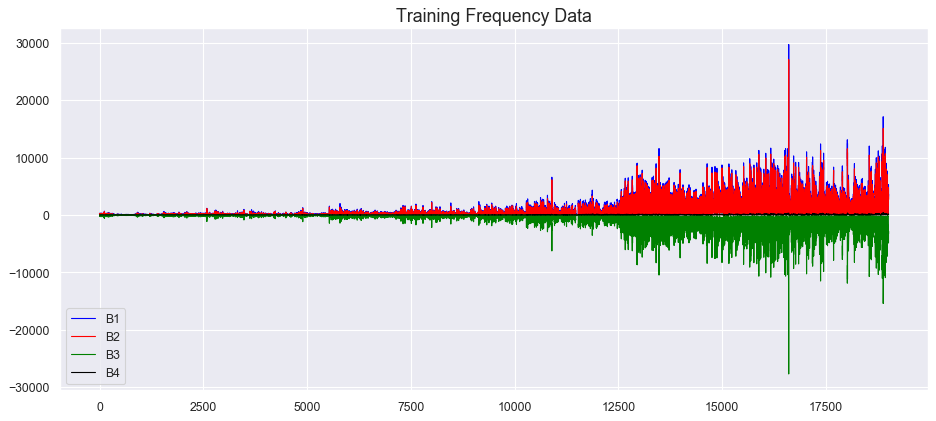

In [122]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='B1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='B2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='B3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='B4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Training Frequency Data', fontsize=16)
plt.show()

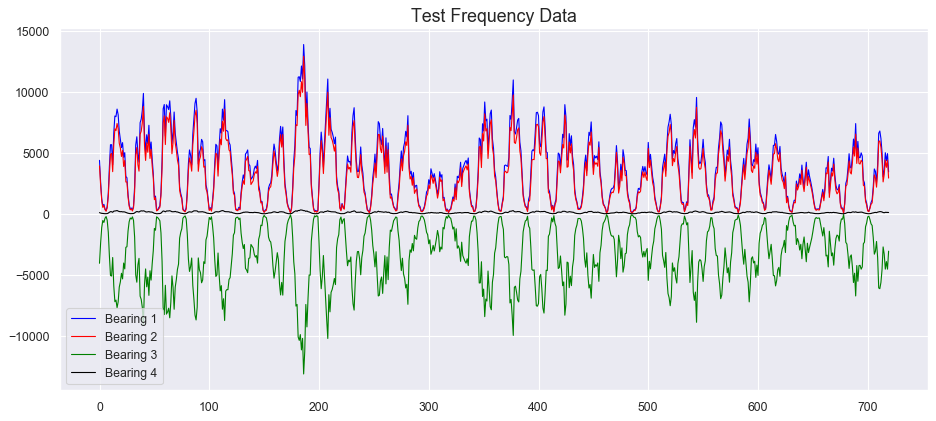

In [123]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Test Frequency Data', fontsize=16)
plt.show()

In [124]:
scaler = MinMaxScaler()

In [125]:
X_train = scaler.fit_transform(train1)
X_test = scaler.fit_transform(test1)

In [126]:
scaler_filename = "scaler_data"

In [127]:
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [128]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (19008, 1, 4)
Test data shape: (720, 1, 4)


In [129]:
X_train[0]

array([[0.02844311, 0.02331288, 0.0238806 , 0.00738775]])

In [130]:
X_test[0]

array([[0.31143552, 0.33096927, 0.23188406, 0.30490211]])

In [131]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [62]:
model = autoencoder_model(X_train)

In [63]:
model

In [64]:
model.compile(optimizer ='adam', loss = 'mae')

In [65]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 4)              68  

In [70]:
nb_epochs = 100
batch_size = 10

In [73]:
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size = batch_size,
                   validation_split=0.05).history

Train on 18057 samples, validate on 951 samples
Epoch 1/100
18057/18057 [==============================] - 8s 441us/step - loss: 0.0365 - val_loss: 0.1014
Epoch 2/100
18057/18057 [==============================] - 8s 417us/step - loss: 0.0365 - val_loss: 0.0993
Epoch 3/100
18057/18057 [==============================] - 8s 437us/step - loss: 0.0365 - val_loss: 0.1018
Epoch 4/100
18057/18057 [==============================] - 8s 466us/step - loss: 0.0365 - val_loss: 0.0998
Epoch 5/100
18057/18057 [==============================] - 7s 403us/step - loss: 0.0365 - val_loss: 0.1017
Epoch 6/100
18057/18057 [==============================] - 8s 423us/step - loss: 0.0365 - val_loss: 0.1007
Epoch 7/100
18057/18057 [==============================] - 8s 425us/step - loss: 0.0365 - val_loss: 0.0980
Epoch 8/100
18057/18057 [==============================] - 8s 458us/step - loss: 0.0365 - val_loss: 0.1002
Epoch 9/100
18057/18057 [==============================] - 8s 419us/step - loss: 0.0365 - val_lo

18057/18057 [==============================] - 7s 403us/step - loss: 0.0365 - val_loss: 0.1008
Epoch 77/100
18057/18057 [==============================] - 7s 398us/step - loss: 0.0365 - val_loss: 0.1001
Epoch 78/100
18057/18057 [==============================] - 7s 408us/step - loss: 0.0365 - val_loss: 0.0995
Epoch 79/100
18057/18057 [==============================] - 8s 435us/step - loss: 0.0365 - val_loss: 0.1021
Epoch 80/100
18057/18057 [==============================] - 7s 409us/step - loss: 0.0365 - val_loss: 0.1007
Epoch 81/100
18057/18057 [==============================] - 8s 425us/step - loss: 0.0365 - val_loss: 0.1018
Epoch 82/100
18057/18057 [==============================] - 8s 430us/step - loss: 0.0365 - val_loss: 0.0995
Epoch 83/100
18057/18057 [==============================] - 7s 411us/step - loss: 0.0365 - val_loss: 0.1005
Epoch 84/100
18057/18057 [==============================] - 8s 420us/step - loss: 0.0365 - val_loss: 0.0993
Epoch 85/100
18057/18057 [===============

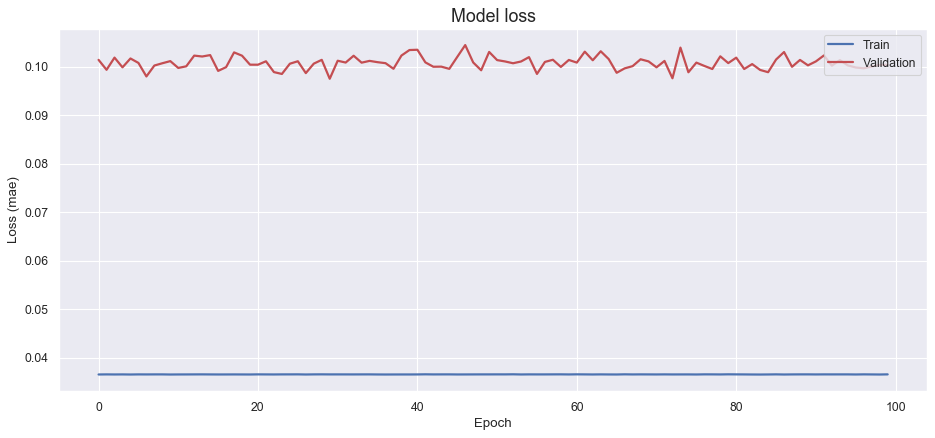

In [132]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

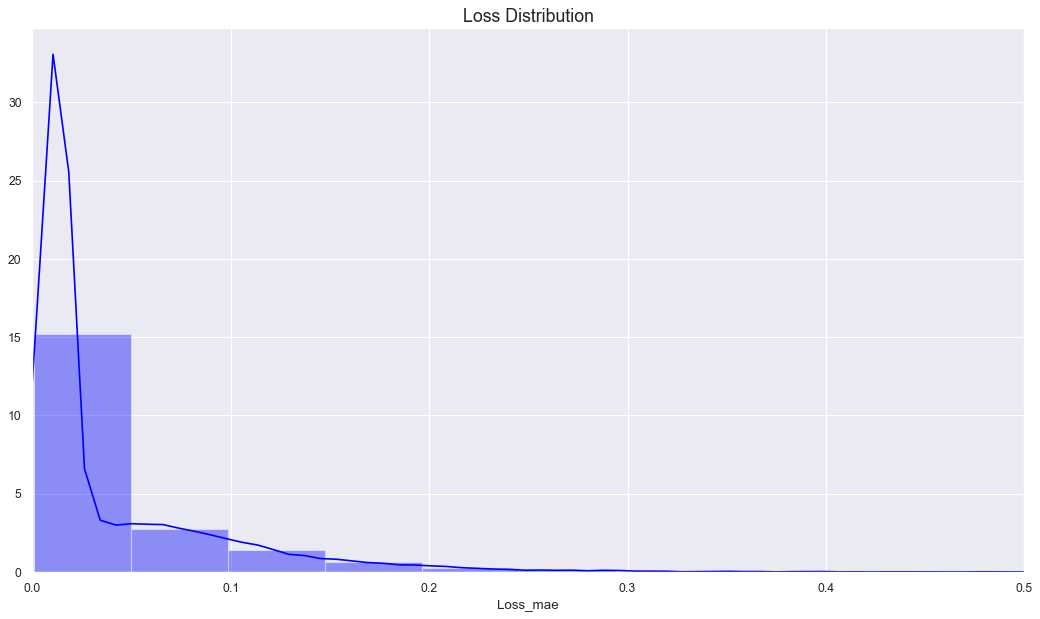

In [133]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train1.columns)
X_pred.index = train1.index

scored = pd.DataFrame(index=train1.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [134]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test1.columns)
X_pred.index = test1.index

scored = pd.DataFrame(index=test1.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
DateTime,,,
2020-11-09 00:00:00,0.274507,0.3,False
2020-11-09 01:00:00,0.154153,0.3,False
2020-11-09 02:00:00,0.073630,0.3,False
2020-11-09 03:00:00,0.025375,0.3,False
2020-11-09 04:00:00,0.034017,0.3,False


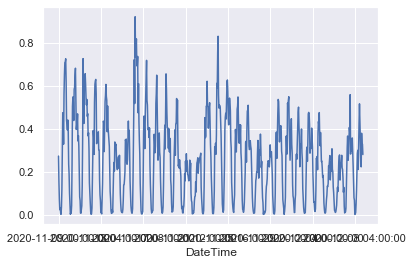

In [135]:
scored['Loss_mae'].plot()

In [136]:
scored['Anomaly'].value_counts()

False    420
True     300
Name: Anomaly, dtype: int64

In [137]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train1.columns)
X_pred_train.index = train1.index

scored_train = pd.DataFrame(index=train1.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

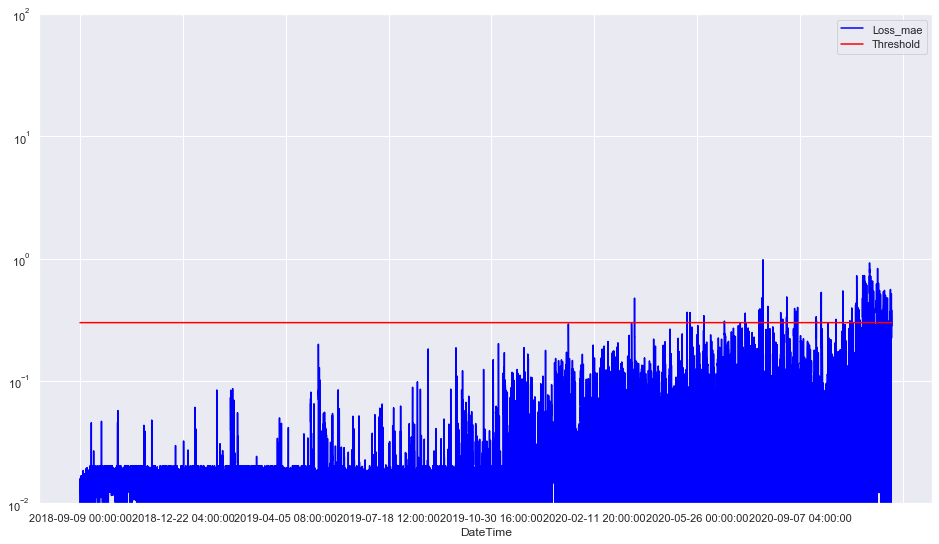

In [138]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [140]:
scored_train['Anomaly'].value_counts()

False    18927
True        81
Name: Anomaly, dtype: int64

In [145]:
scored_train[scored_train['Anomaly'] == True]

,Loss_mae,Threshold,Anomaly
DateTime,,,
2020-03-23 13:00:00,0.475810,0.3,True
2020-05-15 17:00:00,0.364708,0.3,True
2020-05-18 17:00:00,0.362579,0.3,True
2020-06-01 18:00:00,0.342274,0.3,True
2020-06-22 14:00:00,0.308744,0.3,True
...,...,...,...
2020-11-04 17:00:00,0.312983,0.3,True
2020-11-05 14:00:00,0.316597,0.3,True
2020-11-05 15:00:00,0.313773,0.3,True


In [147]:
scored_train[scored_train['Anomaly'] == True].index

Index(['2020-03-23 13:00:00', '2020-05-15 17:00:00', '2020-05-18 17:00:00',
       '2020-06-01 18:00:00', '2020-06-22 14:00:00', '2020-07-13 15:00:00',
       '2020-07-13 16:00:00', '2020-07-13 17:00:00', '2020-07-27 14:00:00',
       '2020-07-27 15:00:00', '2020-07-27 16:00:00', '2020-07-27 17:00:00',
       '2020-07-28 13:00:00', '2020-07-28 14:00:00', '2020-07-28 15:00:00',
       '2020-07-30 16:00:00', '2020-07-30 17:00:00', '2020-07-30 18:00:00',
       '2020-07-31 12:00:00', '2020-07-31 13:00:00', '2020-07-31 14:00:00',
       '2020-07-31 15:00:00', '2020-07-31 16:00:00', '2020-07-31 17:00:00',
       '2020-07-31 18:00:00', '2020-08-05 14:00:00', '2020-08-05 15:00:00',
       '2020-08-18 14:00:00', '2020-08-18 15:00:00', '2020-08-18 16:00:00',
       '2020-08-20 15:00:00', '2020-08-24 11:00:00', '2020-08-24 17:00:00',
       '2020-09-01 15:00:00', '2020-09-01 16:00:00', '2020-09-01 17:00:00',
       '2020-09-03 14:00:00', '2020-09-03 15:00:00', '2020-09-03 16:00:00',
       '2020

In [150]:
true_index = scored_train[scored_train['Anomaly'] == True].index